# Lab 3: Intraday curves and relations between daily data

The goal of this lab is to familiarize you with the `Pandas` library and databases.

You will start by building average intraday curves for several market indicators such as volume, the number of trades, turnover, volatility, spread, imbalance, and the liquidity available at the best quotes (best bid and best ask).

You will then study the relationships between some daily indicators, such as the links between volume and the number of trades, turnover and the number of trades, and finally the spread and volatility per trade.

## I. Importing and reading the data

You have 10 databases in `Pandas` `DataFrame` format, one for each asset across 3 different exchanges:
* **Paris**: Bouygues, LVMH, Sanofi, and Total;
* **Nasdaq**: Amazon, Apple, Google;
* **Tokyo**: Canon, Panasonic, and Sony.

You will need to import the usual Python libraries: `NumPy`, `Pandas`, `MatPlotLib`, and `DateTime` to handle dates/times.

Each `DataFrame` contains all transactions for the year 2011 for the asset and has the same format:
* the `Time` index is the transaction timestamp;
* the `TradedPrice` column is the average price per share of the transaction;
* the `TradedQty` column is the transaction volume;
* the `BidPrice` column is the best bid price just before the transaction;
* the `AskPrice` column is the best ask price just before the transaction;
* the `BidQty` column is the quantity at the best bid just before the transaction;
* the `AskQty` column is the quantity at the best ask just before the transaction;
* the `TradedSign` column is the sign of the trade (negative for bid and positive for ask).

The `Time` index of the time series is in Python `DateTime` format. You can therefore extract dates, as well as the year, month, day, hour, minute, etc.

In [42]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LinearRegression

In [43]:
os.listdir()

['.DS_Store', 'TP 3 - Intraday Curves_EN.ipynb', 'Data']

In [44]:
data_folder = "Data"
files = os.listdir(data_folder)
DATAS = {}

for f in files:
    if f.endswith('.h5'):
        key = f.replace(".h5", "").strip().lower()
        DATAS[key] = pd.read_hdf(f'Data/{f}')

DATAS['lvmh'].head()

,TradedPrice,TradedQty,BidPrice,AskPrice,BidQty,AskQty,TradedSign
Time,,,,,,,
2011-01-03 09:00:01.616,124.5,75,124.0,124.05,52600,63900,2
2011-01-03 09:00:01.616,124.5,42,124.0,124.05,52600,63900,2
2011-01-03 09:00:01.616,124.5,12,124.0,124.05,52600,63900,2
2011-01-03 09:00:01.616,124.5,1,124.0,124.05,52600,63900,2
2011-01-03 09:00:01.616,124.5,3,124.0,124.05,52600,63900,2


In [45]:
test = DATAS['lvmh']
test

,TradedPrice,TradedQty,BidPrice,AskPrice,BidQty,AskQty,TradedSign
Time,,,,,,,
2011-01-03 09:00:01.616,124.50,75,124.00,124.05,52600,63900,2
2011-01-03 09:00:01.616,124.50,42,124.00,124.05,52600,63900,2
2011-01-03 09:00:01.616,124.50,12,124.00,124.05,52600,63900,2
2011-01-03 09:00:01.616,124.50,1,124.00,124.05,52600,63900,2
2011-01-03 09:00:01.616,124.50,3,124.00,124.05,52600,63900,2
...,...,...,...,...,...,...,...
2011-12-30 17:29:34.358,109.10,100,109.10,109.25,27300,878700,-1
2011-12-30 17:29:34.358,109.10,173,109.10,109.25,27300,878700,-1
2011-12-30 17:29:34.358,109.10,227,109.10,109.25,27300,878700,-1


In [46]:
FR_stocks = {'bouygues','lvmh','sanofi','total'}
US_stocks = {'amazon','apple','google'}
JPN_stocks = {'canon','panasonic','sony'}

FR_schedule = pd.date_range(start = "09:00",end = "17:30",freq = "5min").strftime("%H:%M")
US_schedule = pd.date_range(start = "09:30",end = "16:00",freq = "5min").strftime("%H:%M")
JPN_schedule= pd.date_range(start = "09:00",end = "15:00",freq = "5min").strftime("%H:%M")

## II. Intraday curves for different indicators

You must produce average intraday curves over the year in 5-minute buckets, expressed as percentages (to compare assets), and make one plot per exchange with the 3 or 4 assets on each. You will then comment on the results obtained for each curve (shape of the curve, peaks, etc.).

You may use the `resample` function in `Pandas`, which allows you to resample to the desired frequency and compute statistics at that frequency (such as sum, mean, variance, minimum, maximum, etc.).

### 1. Volume curves

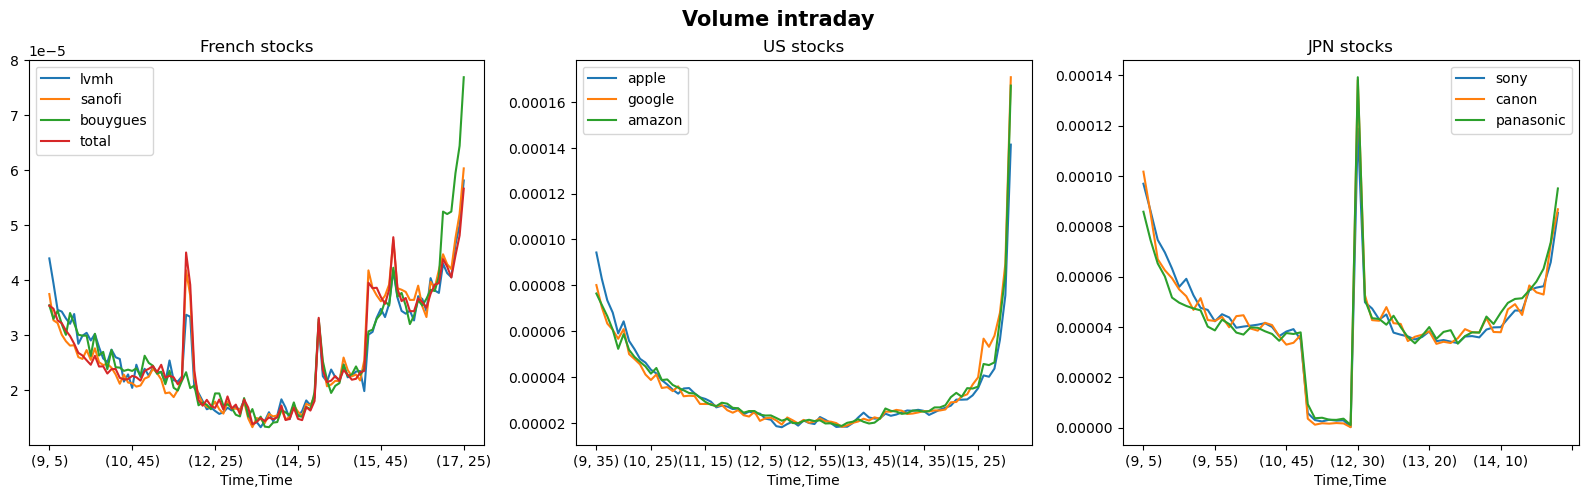

In [47]:
fig, axes = plt.subplots(1,3,figsize = (20,5))
fig.suptitle('Volume intraday', fontsize = 15, fontweight = 'bold')

def plot_volumes(stock_list,country,schedule,ax):
    for stk in stock_list:
        DATAS[stk]["Volume"] = DATAS[stk].TradedQty / DATAS[stk].TradedQty.sum()
        resampled = DATAS[stk].Volume.resample("5min").sum()
        resampled = resampled.groupby([resampled.index.hour,resampled.index.minute]).mean()
        resampled = resampled[resampled != .0][1:-1]
        if country == "JPN Stocks":
            lunch_break = [(k,i) for k in [11,12] for i in range(35,60,5)]
            new_idx = sorted(list(resampled.index.to_flat_index())+lunch_break , key=lambda k: [k[0], k[1]])
            resampled = resampled.reindex(new_idx, fill_value=0)
        resampled.plot(label = stk,title = country,ax = ax)
    ax.legend()
    return

plot_volumes(FR_stocks,'French stocks',FR_schedule,axes[0])
plot_volumes(US_stocks,'US stocks',US_schedule,axes[1])
plot_volumes(JPN_stocks,'JPN stocks',JPN_schedule,axes[2])

*Comments*

### 2. Trade count curves

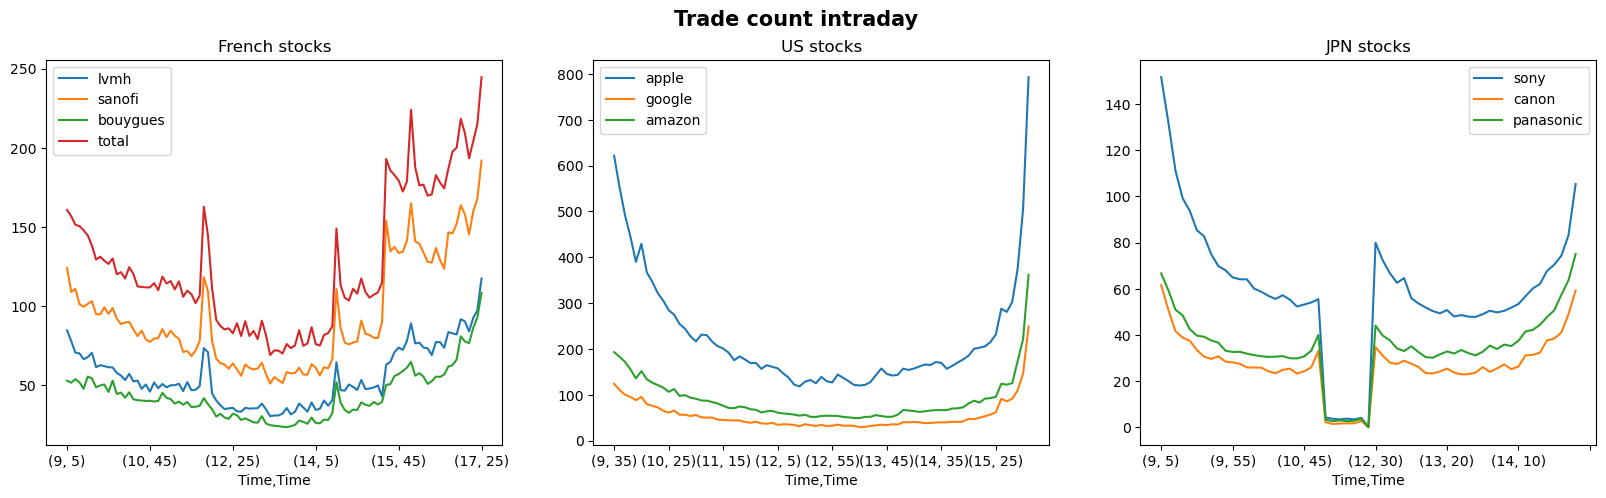

In [48]:
fig, axes = plt.subplots(1,3,figsize = (20,5))
fig.suptitle('Trade count intraday', fontsize = 15, fontweight = 'bold')

def plot_trade_count(stock_list,country,schedule,ax):
    for stk in stock_list:
        resampled = DATAS[stk].TradedQty.resample("5min").size()
        resampled = resampled.groupby([resampled.index.hour,resampled.index.minute]).mean()
        resampled = resampled[resampled != .0][1:-1]
        if country == "JPN Stocks":
            lunch_break = [(k,i) for k in [11,12] for i in range(35,60,5)]
            new_idx = sorted(list(resampled.index.to_flat_index())+lunch_break , key=lambda k: [k[0], k[1]])
            resampled = resampled.reindex(new_idx, fill_value=0)
        resampled.plot(label = stk,title = country,ax = ax)
    ax.legend()
    return

plot_trade_count(FR_stocks,'French stocks',FR_schedule,axes[0])
plot_trade_count(US_stocks,'US stocks',US_schedule,axes[1])
plot_trade_count(JPN_stocks,'JPN stocks',JPN_schedule,axes[2])

*Comments*

### 3. Turnover (cash) curves

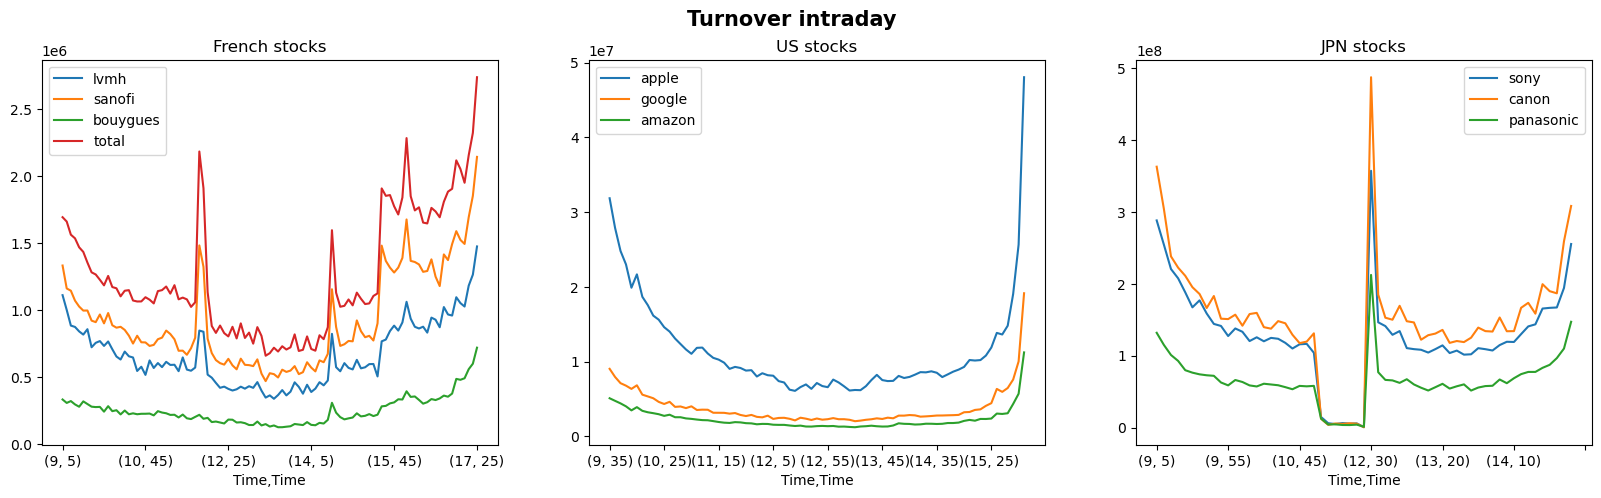

In [55]:
fig, axes = plt.subplots(1,3,figsize = (20,5))
fig.suptitle('Turnover intraday', fontsize = 15, fontweight = 'bold')

def plot_turnover(stock_list,country,schedule,ax):
    for stk in stock_list:
        # DATAS[stk]["Turnover"] = DATAS[stk].TradedQty * 0.5*(DATAS[stk].BidPrice + DATAS[stk].AskPrice)
        DATAS[stk]["Turnover"] = DATAS[stk].TradedQty * DATAS[stk].TradedPrice
        resampled = DATAS[stk].Turnover.resample("5min").sum()
        resampled = resampled.groupby([resampled.index.hour,resampled.index.minute]).mean()
        resampled = resampled[resampled != .0][1:-1]
        if country == "JPN Stocks":
            lunch_break = [(k,i) for k in [11,12] for i in range(35,60,5)]
            new_idx = sorted(list(resampled.index.to_flat_index())+lunch_break , key=lambda k: [k[0], k[1]])
            resampled = resampled.reindex(new_idx, fill_value=0)
        resampled.plot(label = stk,title = country,ax = ax)
    ax.legend()
    return

plot_turnover(FR_stocks,'French stocks',FR_schedule,axes[0])
plot_turnover(US_stocks,'US stocks',US_schedule,axes[1])
plot_turnover(JPN_stocks,'JPN stocks',JPN_schedule,axes[2])

*Comments*

### 4. Average spread curves

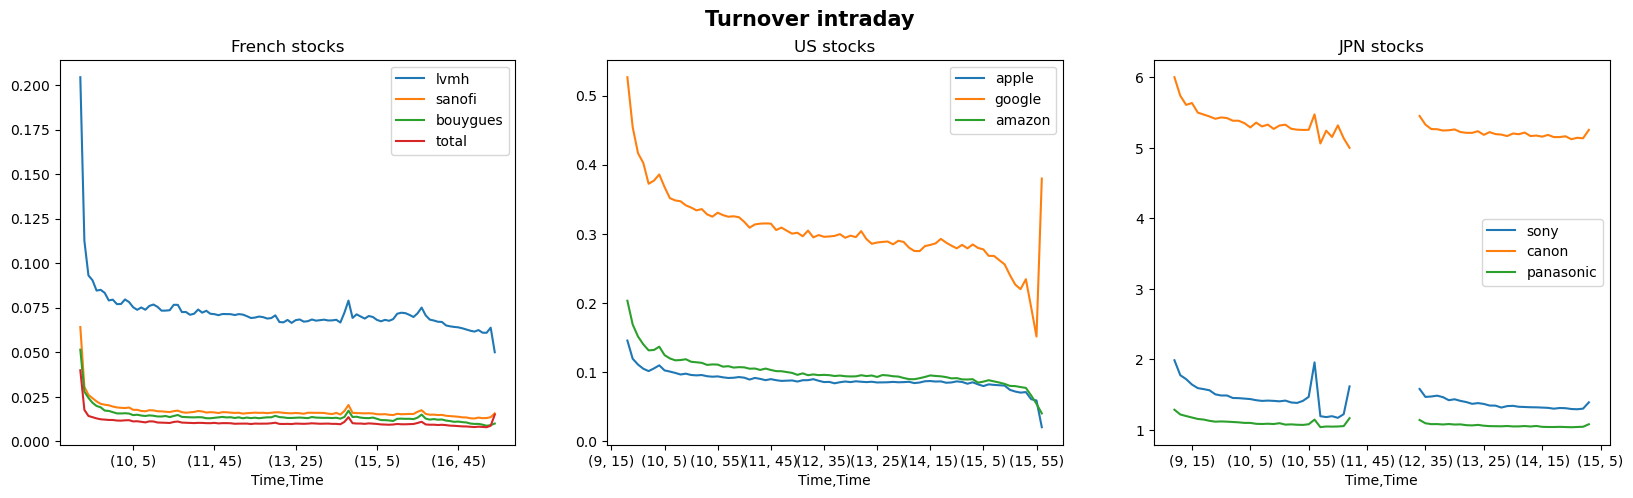

In [64]:
fig, axes = plt.subplots(1,3,figsize = (20,5))
fig.suptitle('Turnover intraday', fontsize = 15, fontweight = 'bold')

def plot_mean_spread(stock_list,country,schedule,ax):
    for stk in stock_list:
        DATAS[stk]["Spread"] = abs(DATAS[stk].BidPrice - DATAS[stk].AskPrice)
        resampled = DATAS[stk].Spread.resample("5min").mean()
        resampled = resampled.groupby([resampled.index.hour,resampled.index.minute]).mean()
        resampled = resampled[resampled != .0][1:-1]
        if country == "JPN Stocks":
            lunch_break = [(k,i) for k in [11,12] for i in range(35,60,5)]
            new_idx = sorted(list(resampled.index.to_flat_index())+lunch_break , key=lambda k: [k[0], k[1]])
            resampled = resampled.reindex(new_idx, fill_value=0)
        resampled.plot(label = stk,title = country,ax = ax)
    ax.legend()
    return

plot_mean_spread(FR_stocks,'French stocks',FR_schedule,axes[0])
plot_mean_spread(US_stocks,'US stocks',US_schedule,axes[1])
plot_mean_spread(JPN_stocks,'JPN stocks',JPN_schedule,axes[2])

*Comments*

### 5. Volatility curves

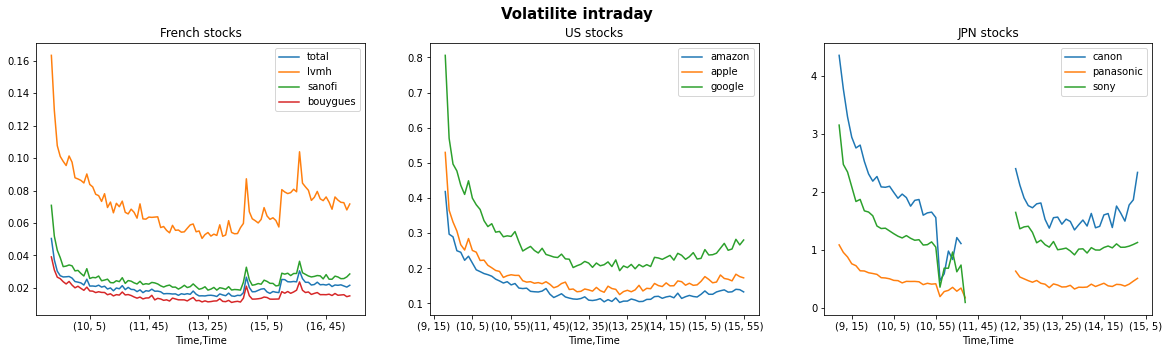

*Comments*

### 6. Imbalance curves (unsigned $|Q_{ask}-Q_{bid}|/(Q_{ask}+Q_{bid})$ or signed $(Q_{ask}-Q_{bid})/(Q_{ask}+Q_{bid})$)

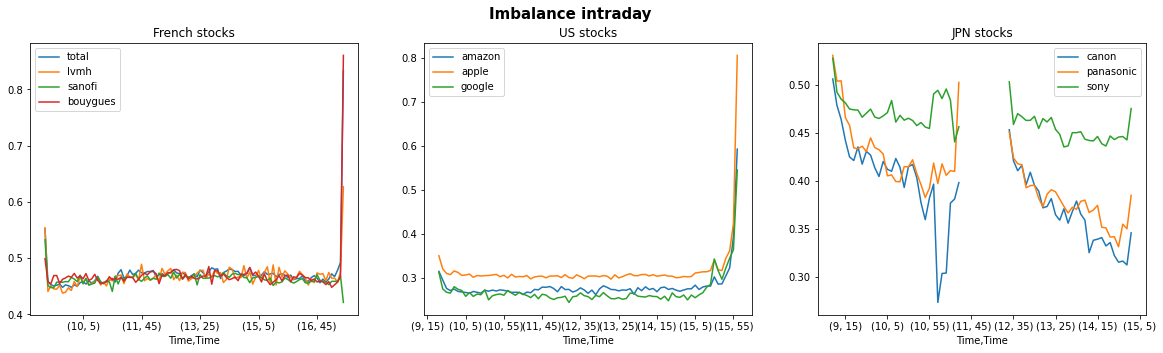

*Comments*

### 7. Curves of quantities at the best quotes $Q_{ask}+Q_{bid}$

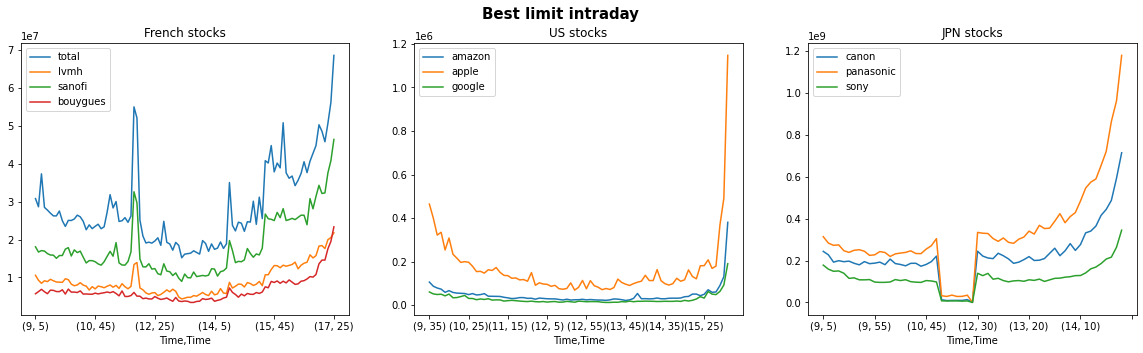

*Comments*

## III. Relationships between daily indicators

You will now look at the relationship between some daily indicators using linear regressions:
* relationship between volumes and numbers of trades,
* between turnovers and numbers of trades,
* between volatility per trade and the bid-ask spread.

As before, you will make one plot per exchange with the 3 or 4 assets on each. You will then comment on the results obtained for each relationship.

### 1. Volume/Trades relationship

In [ ]:
def plot_volume_trades(stock_list):
    fig, ax = plt.subplots(1,len(stock_list),figsize = (20,5))
    fig.suptitle('LinReg : TradedQty vs Volume', fontsize = 15, fontweight = 'bold')
    plot_idx = 0    
    for stk in stock_list:
        DATAS[stk]['Volume'] = DATAS[stk].TradedQty / DATAS[stk].TradedQty.sum()
        x,y = np.array(DATAS[stk].Volume).reshape(-1, 1), np.array(DATAS[stk].TradedQty).reshape(-1, 1)
        model = LinearRegression().fit(x,y)
        ax[plot_idx].scatter(x, y, label = stk, color = "black")
        ax[plot_idx].plot(x, model.predict(x), label = "reg", color = "red")
        ax[plot_idx].legend()
        fig.text(0.5, 0.04, 'Volume', ha='center', va='center')
        fig.text(0.06, 0.5, 'TradedQty', ha='center', va='center', rotation='vertical')
        plot_idx += 1
    return

plot_volume_trades(FR_stocks)

Error in callback <function flush_figures at 0x000001F3FCAEA268> (for post_execute):


KeyboardInterrupt: 

In [ ]:
plot_volume_trades(US_stocks)

In [ ]:
plot_volume_trades(JPN_stocks)

### 2. Turnover/Trades relationship

*Comments*

### 3. Volatility per trade / bid-ask spread relationship

Volatility can be viewed as a measure of the amount of information contained in the price. In practice, this information is correlated with the order flow, which anticipates or triggers price movements.

It is well known that the spread and volatility are closely linked: while the spread sets the profit per transaction for market makers, volatility determines the adverse selection they have to face.
In any model where market makers break even, one needs an equation that pins down the relationship between the bid-ask spread and volatility.

This relationship has been the subject of several models attempting to justify it at the microscopic level, since it is observed empirically in the data.

In the simplest possible model by Madhavan, Richardson and Roomans (MRR) in 1997, one obtains:
$$\varphi=c\sigma_{mid} N^{-1/2},$$
where $\varphi$ is the bid-ask spread, $\sigma_{mid}$ is the volatility of the mid price, $N$ is the number of transactions, and $c>0$.

*Comments*